In [336]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
import datetime

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

import torch
from torch.autograd import Variable
from torch import nn

In [337]:
# Read the data
df = pd.read_csv("CRUS_stock_2016_2023.csv")

In [338]:
df

,Date,Open,High,Low,Close,Volume
0,2016-01-04,29.35,29.45,28.31,29.30,1569911
1,2016-01-05,29.48,29.54,27.32,27.56,3932534
2,2016-01-06,27.07,27.92,26.73,26.80,3669946
3,2016-01-07,26.10,27.15,25.65,26.80,3080217
4,2016-01-08,27.51,29.45,27.32,27.80,7873216
...,...,...,...,...,...,...
1882,2023-12-04,75.77,77.19,75.57,77.02,339059
1883,2023-12-05,76.38,78.26,75.80,78.10,499485
1884,2023-12-06,78.74,79.40,77.44,77.73,290438
1885,2023-12-07,77.98,78.59,77.46,78.56,284243


## Exploratory Data Analysis (EDA)

In [339]:
# View the first few rows
df.head(5)

,Date,Open,High,Low,Close,Volume
0,2016-01-04,29.35,29.45,28.31,29.30,1569911
1,2016-01-05,29.48,29.54,27.32,27.56,3932534
2,2016-01-06,27.07,27.92,26.73,26.80,3669946
3,2016-01-07,26.10,27.15,25.65,26.80,3080217
4,2016-01-08,27.51,29.45,27.32,27.80,7873216


In [340]:
print(f"Number of Rows: {len(df)}") # Find number of rows
print(f"Number of Columns: {len(df.iloc[0])}") # Number of Columns

Number of Rows: 1887
Number of Columns: 6


In [341]:
df.info() # See the data types of each column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1887 entries, 0 to 1886
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1887 non-null   object 
 1   Open    1887 non-null   float64
 2   High    1887 non-null   float64
 3   Low     1887 non-null   float64
 4   Close   1887 non-null   float64
 5   Volume  1887 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 88.6+ KB


In [342]:
# Convert the date to datetime
df["Date"] = pd.to_datetime(df["Date"])

In [343]:
# Check for missing values
df.isnull().sum(axis = 0) # There seem to be no missing values

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [344]:
# Descriptive Statistics
df[df.columns[1:]].describe() # Not including Date

,Open,High,Low,Close,Volume
count,1887.000000,1887.000000,1887.000000,1887.000000,1.887000e+03
mean,62.998972,63.947287,62.058824,63.007578,8.309104e+05
std,18.502445,18.717410,18.254854,18.485537,7.496929e+05
min,25.710000,27.140000,25.090000,25.760000,1.464730e+05
25%,45.390000,46.270000,44.770000,45.265000,4.445150e+05
50%,64.100000,65.130000,63.270000,64.170000,6.417620e+05
75%,78.545000,79.725000,77.470000,78.560000,9.645745e+05
max,109.460000,111.150000,108.860000,109.560000,1.071858e+07


### Time Series Analysis

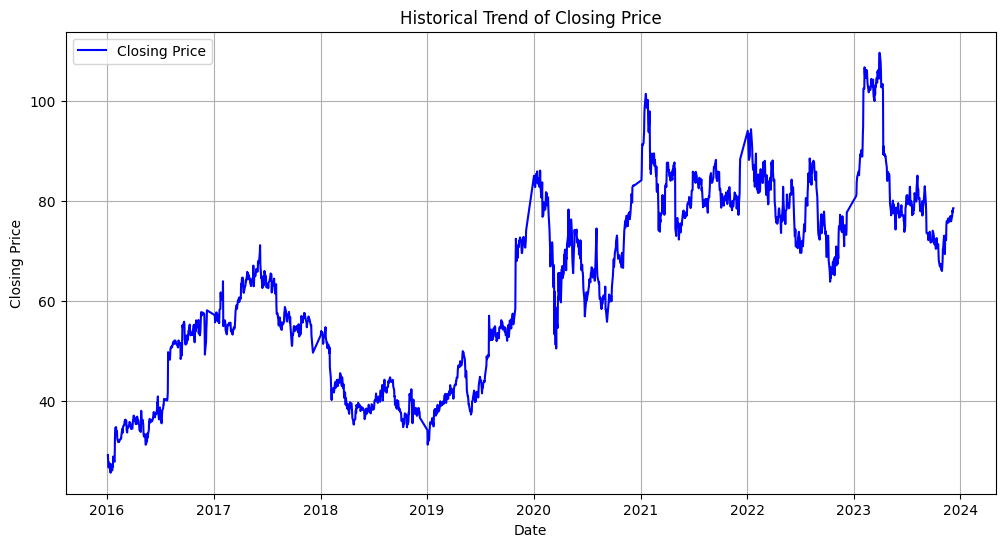

In [345]:
# Plotting the historical trend of the closing price
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], label='Closing Price', color='blue')
plt.title('Historical Trend of Closing Price')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.show()

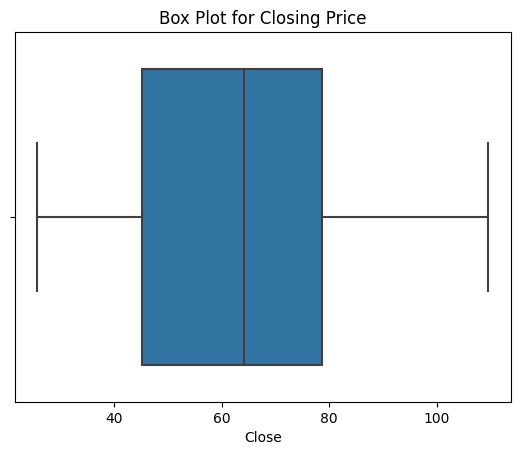

In [346]:
# Look for anomalies
sns.boxplot(x=df['Close'])
plt.title('Box Plot for Closing Price')
plt.show() # There appear to be no outliers in the closing price

### Correlation Analysis

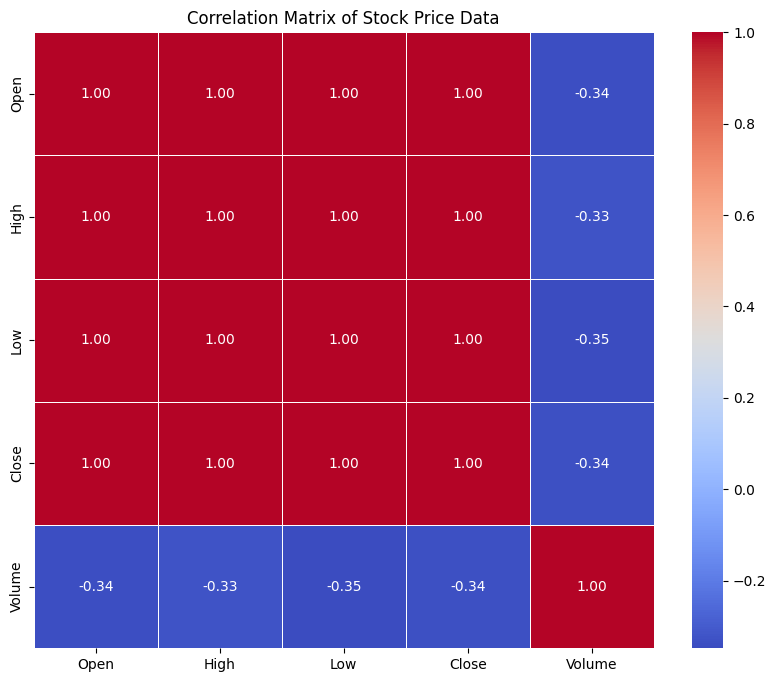

In [347]:
# Calculate the correlation matrix
correlation_matrix = df[['Open', 'High', 'Low', 'Close', 'Volume']].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix of Stock Price Data')
plt.show()

The import insight to be gained here is that the number of stocks does not seem to have much correlation with the price of the stock

### Lag Analysis

In [348]:
lag_steps = 5  

# Create lag features
for i in range(1, lag_steps + 1):
    df[f'Close_Lag_{i}'] = df['Close'].shift(i)

# Display the DataFrame with lag features
df.head(5)

,Date,Open,High,Low,Close,Volume,Close_Lag_1,Close_Lag_2,Close_Lag_3,Close_Lag_4,Close_Lag_5
0,2016-01-04,29.35,29.45,28.31,29.30,1569911,NaN,NaN,NaN,NaN,NaN
1,2016-01-05,29.48,29.54,27.32,27.56,3932534,29.30,NaN,NaN,NaN,NaN
2,2016-01-06,27.07,27.92,26.73,26.80,3669946,27.56,29.30,NaN,NaN,NaN
3,2016-01-07,26.10,27.15,25.65,26.80,3080217,26.80,27.56,29.30,NaN,NaN
4,2016-01-08,27.51,29.45,27.32,27.80,7873216,26.80,26.80,27.56,29.3,NaN


<Figure size 1000x600 with 0 Axes>

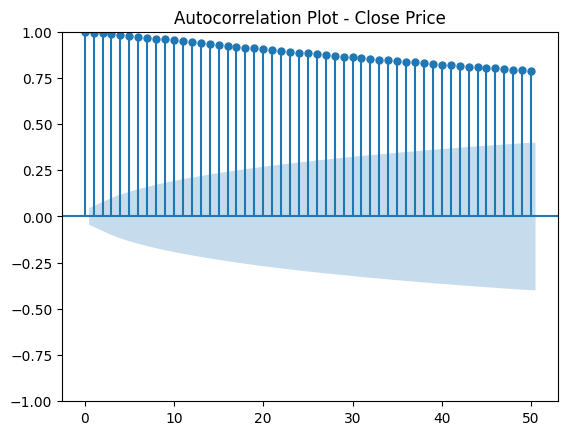

<Figure size 1000x600 with 0 Axes>

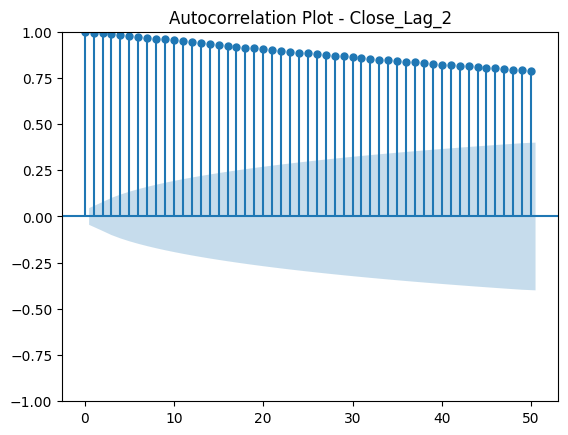

<Figure size 1000x600 with 0 Axes>

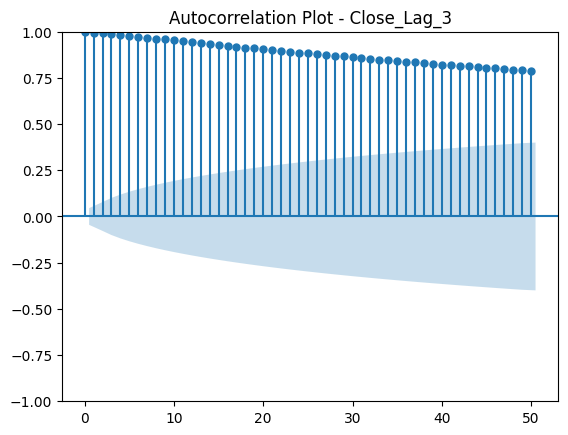

<Figure size 1000x600 with 0 Axes>

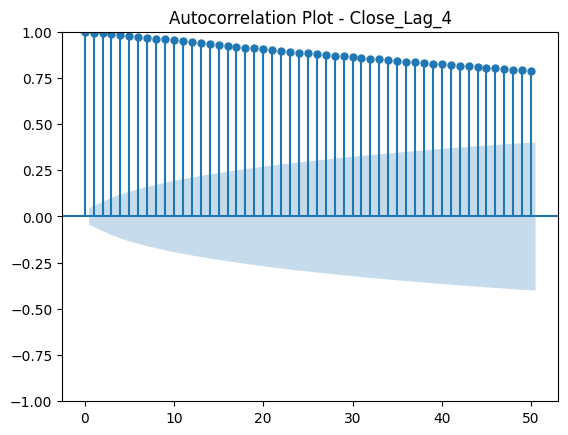

<Figure size 1000x600 with 0 Axes>

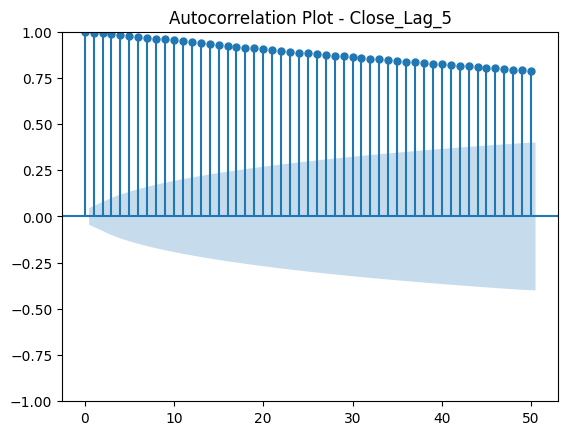

In [349]:
# Plot autocorrelation for a specific column
plt.figure(figsize=(10, 6))
plot_acf(df['Close'], lags=50, title='Autocorrelation Plot - Close Price')
plt.show()

# Plot autocorrelation for a specific lag feature 
for close_lag in df.columns[7:]:
    plt.figure(figsize=(10, 6))
    plot_acf(df[close_lag].dropna(), lags=50, title=f'Autocorrelation Plot - {close_lag}')
    plt.show()

### Seasonal Analysis

In [350]:
result = seasonal_decompose(df['Close'], model='additive', period=365)

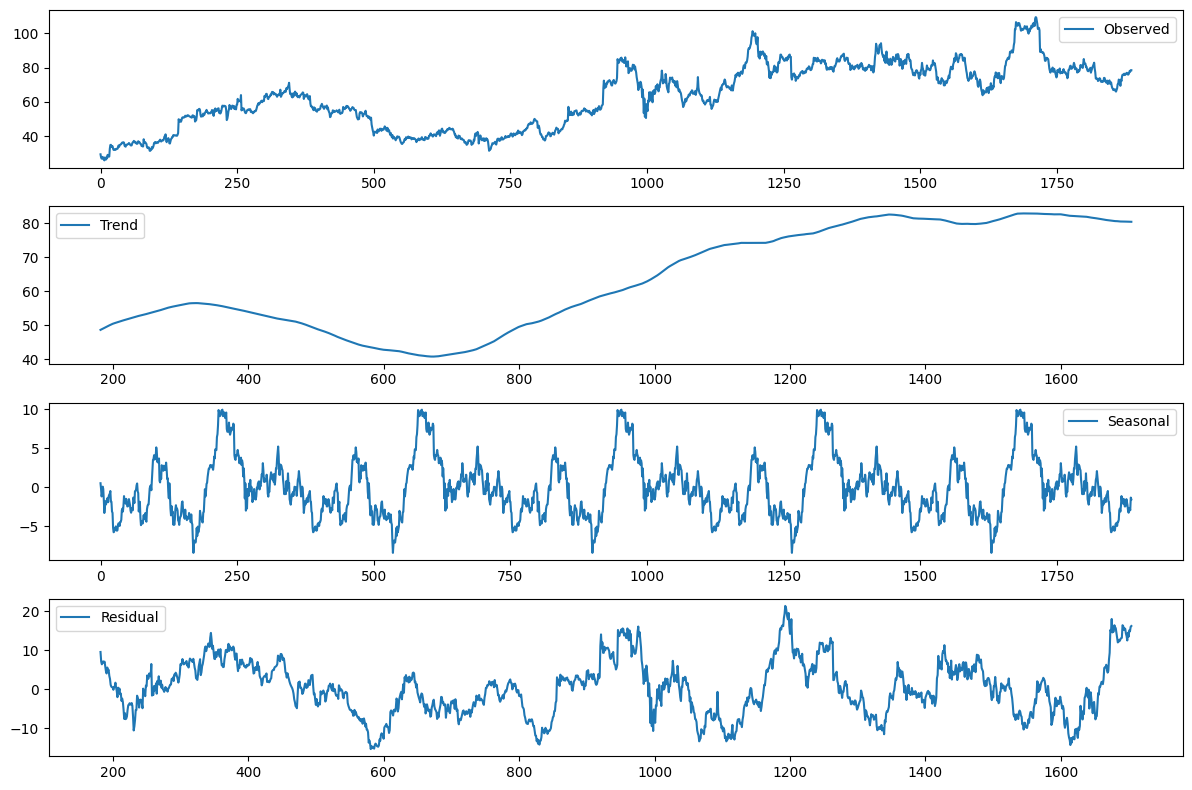

In [351]:
# Plot decomposed components
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(result.observed, label='Observed')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Trend')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Seasonal')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residual')
plt.legend()

plt.tight_layout()
plt.show()

In [352]:
# Observe seasonal patterns in one year (2022)
df["Date"].dt.year.unique()

array([2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023])

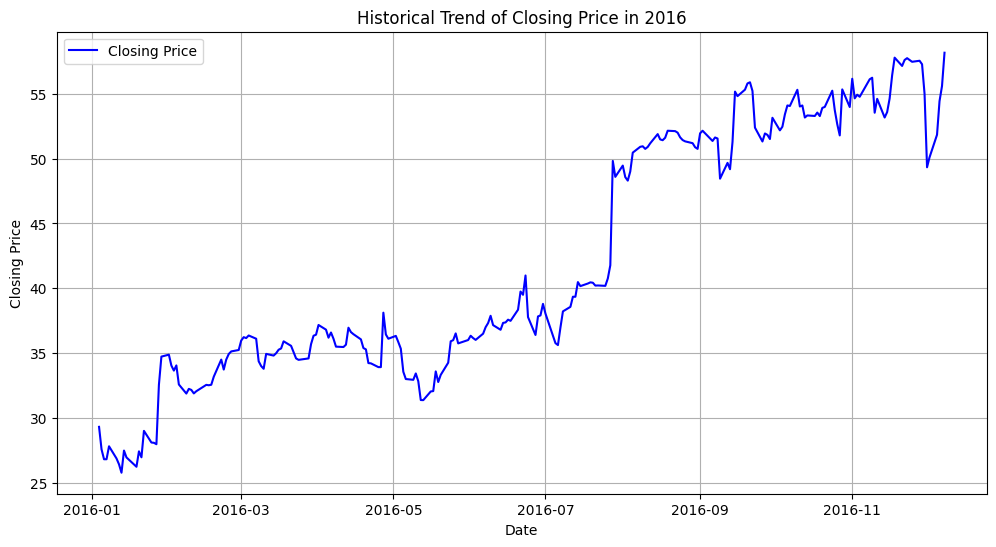

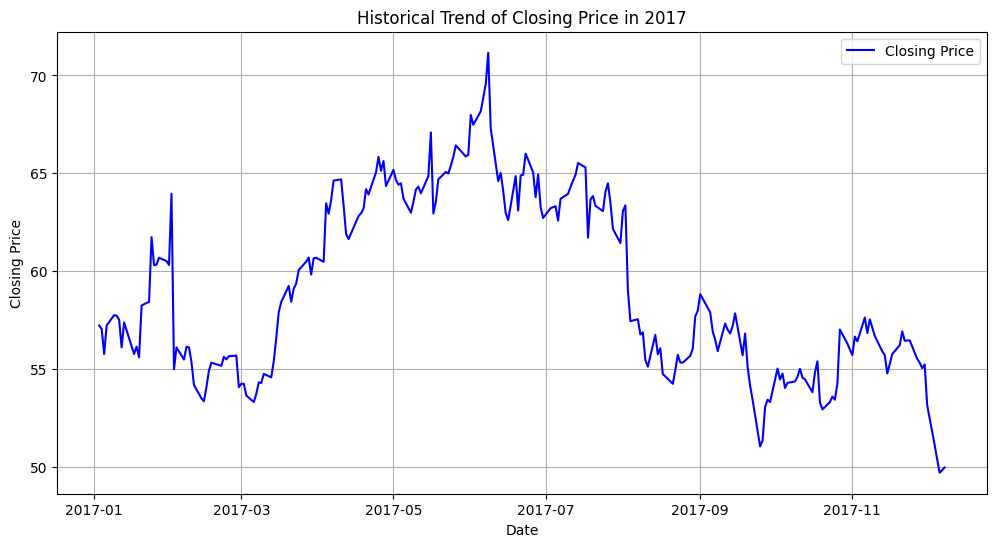

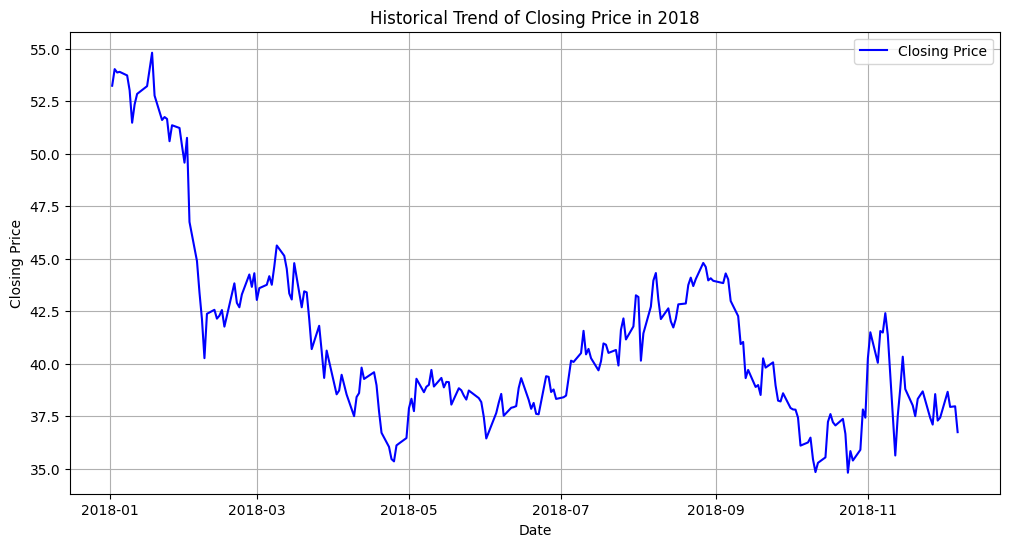

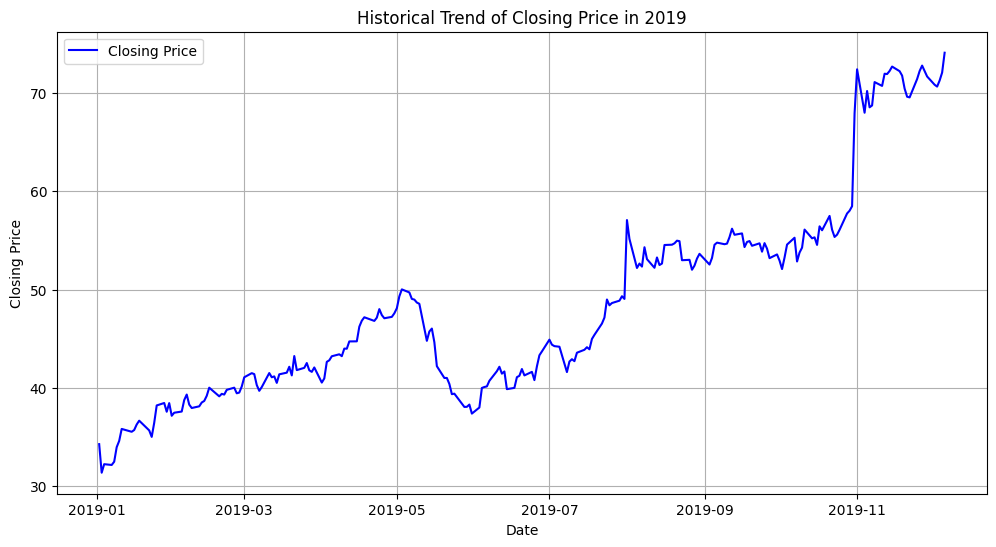

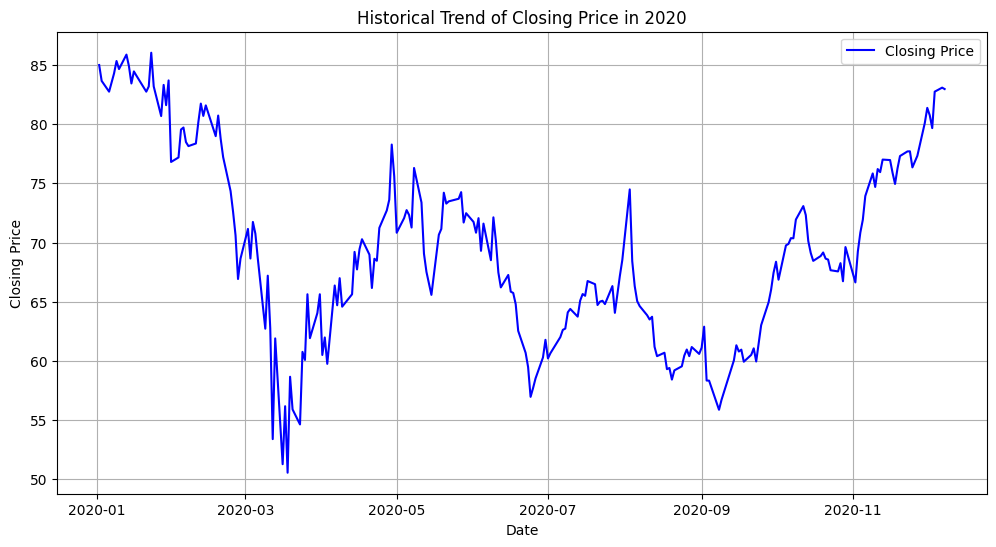

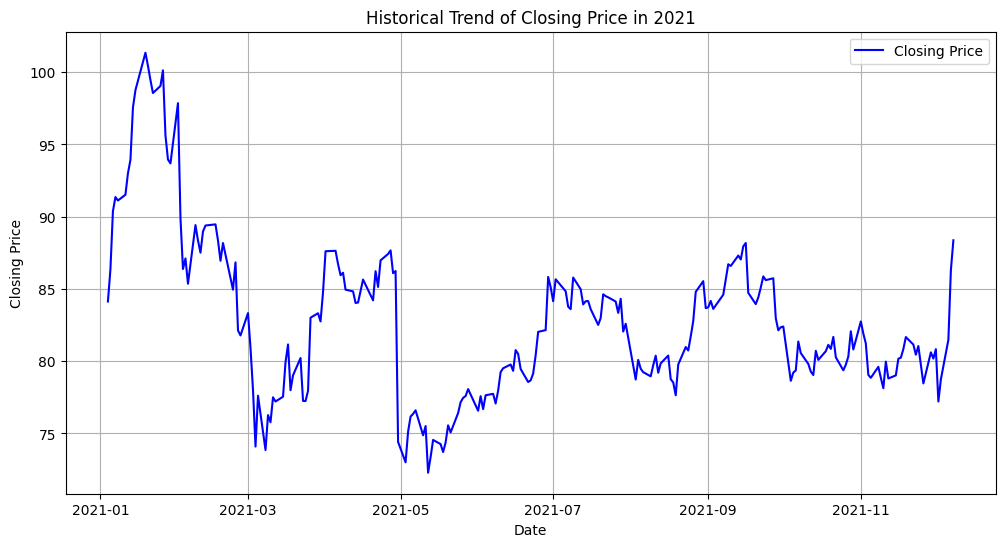

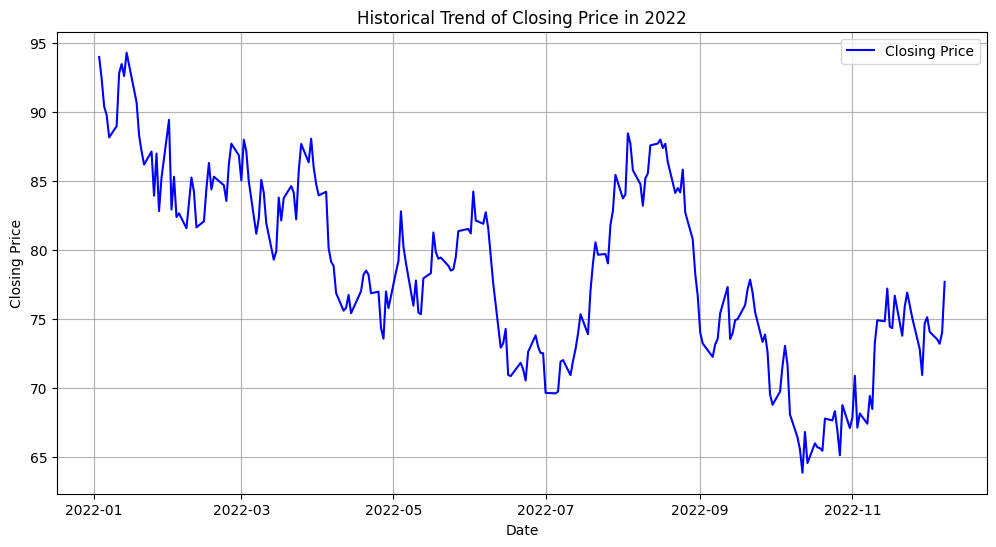

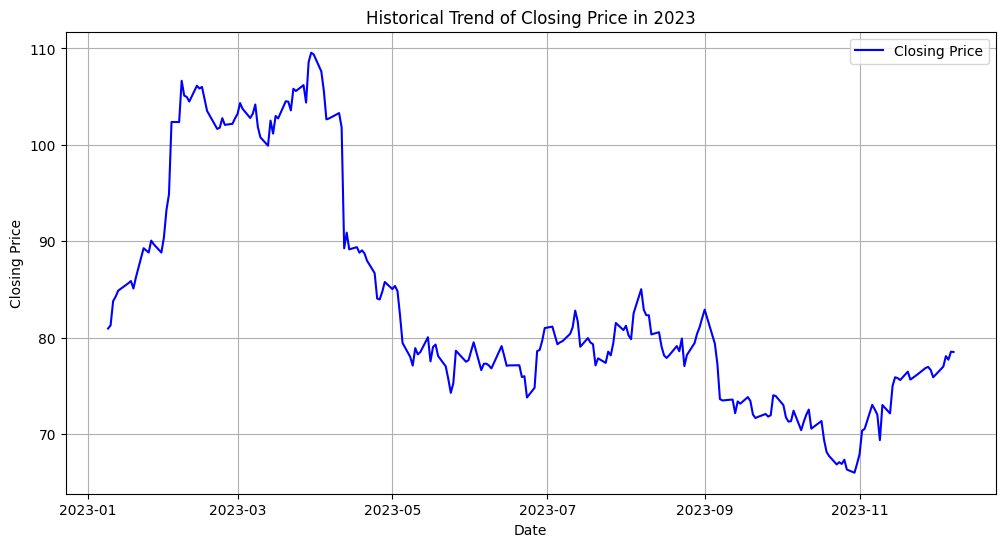

In [353]:
# Plotting the historical trend of the closing price in 2022
for year in df["Date"].dt.year.unique():
    plt.figure(figsize=(12, 6))
    plt.plot(df[df["Date"].dt.year == year]["Date"], df[df["Date"].dt.year == year]["Close"], label='Closing Price', color='blue')
    plt.title(f'Historical Trend of Closing Price in {year}')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.grid(True)
    plt.show()

## Model Prediction

### Random Forest Regressor

In [354]:
df = df.dropna()

In [355]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close_Lag_1',
       'Close_Lag_2', 'Close_Lag_3', 'Close_Lag_4', 'Close_Lag_5'],
      dtype='object')

In [356]:
features = ['Close_Lag_1', 'Close_Lag_2', 'Close_Lag_3', 'Close_Lag_4',
       'Close_Lag_5']
X = df[features]
y = df['Close']

In [362]:
df

,Date,Open,High,Low,Close,Volume,Close_Lag_1,Close_Lag_2,Close_Lag_3,Close_Lag_4,Close_Lag_5
5,2016-01-11,27.90,28.36,26.43,26.86,3166615,27.80,26.80,26.80,27.56,29.30
6,2016-01-12,27.12,27.64,26.02,26.41,1802831,26.86,27.80,26.80,26.80,27.56
7,2016-01-13,26.40,27.14,25.67,25.76,2040123,26.41,26.86,27.80,26.80,26.80
8,2016-01-14,25.71,27.79,25.09,27.47,3439707,25.76,26.41,26.86,27.80,26.80
9,2016-01-15,26.65,27.18,26.00,26.94,2458140,27.47,25.76,26.41,26.86,27.80
...,...,...,...,...,...,...,...,...,...,...,...
1882,2023-12-04,75.77,77.19,75.57,77.02,339059,76.18,75.91,76.67,76.98,76.87
1883,2023-12-05,76.38,78.26,75.80,78.10,499485,77.02,76.18,75.91,76.67,76.98
1884,2023-12-06,78.74,79.40,77.44,77.73,290438,78.10,77.02,76.18,75.91,76.67
1885,2023-12-07,77.98,78.59,77.46,78.56,284243,77.73,78.10,77.02,76.18,75.91


In [372]:
df[(df["Date"].dt.year <= 2023) & (df["Date"].dt.month <= 11)]

,Date,Open,High,Low,Close,Volume,Close_Lag_1,Close_Lag_2,Close_Lag_3,Close_Lag_4,Close_Lag_5
5,2016-01-11,27.90,28.36,26.43,26.86,3166615,27.80,26.80,26.80,27.56,29.30
6,2016-01-12,27.12,27.64,26.02,26.41,1802831,26.86,27.80,26.80,26.80,27.56
7,2016-01-13,26.40,27.14,25.67,25.76,2040123,26.41,26.86,27.80,26.80,26.80
8,2016-01-14,25.71,27.79,25.09,27.47,3439707,25.76,26.41,26.86,27.80,26.80
9,2016-01-15,26.65,27.18,26.00,26.94,2458140,27.47,25.76,26.41,26.86,27.80
...,...,...,...,...,...,...,...,...,...,...,...
1876,2023-11-24,75.78,77.34,75.54,76.24,220096,75.85,75.67,76.49,75.62,75.82
1877,2023-11-27,76.01,77.14,75.54,76.87,454830,76.24,75.85,75.67,76.49,75.62
1878,2023-11-28,76.40,77.22,76.23,76.98,448547,76.87,76.24,75.85,75.67,76.49
1879,2023-11-29,77.79,78.60,76.52,76.67,406922,76.98,76.87,76.24,75.85,75.67


In [416]:
X_test

,Close_Lag_1,Close_Lag_2,Close_Lag_3,Close_Lag_4,Close_Lag_5
1649,74.71,70.96,72.85,75.11,76.93
1650,75.14,74.71,70.96,72.85,75.11
1651,74.09,75.14,74.71,70.96,72.85
1652,73.54,74.09,75.14,74.71,70.96
1653,73.22,73.54,74.09,75.14,74.71
...,...,...,...,...,...
1882,76.18,75.91,76.67,76.98,76.87
1883,77.02,76.18,75.91,76.67,76.98
1884,78.10,77.02,76.18,75.91,76.67
1885,77.73,78.10,77.02,76.18,75.91


In [490]:
# Temporal Split
cutoff_year = 2022
cutoff_month = 12
cutoff_day = 31

# Split the data into training and testing sets based on the cutoff year
train_mask = df[(df["Date"].dt.year <= cutoff_year) & (df["Date"].dt.month <= cutoff_month) & (df["Date"].dt.day <= cutoff_day)]
cutoff_length = len(train_mask)

X_train, X_test, y_train, y_test = X[:cutoff_length], X[cutoff_length:], y[:cutoff_length], y[cutoff_length:]

In [471]:
# Instantiate and train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [472]:
# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 11.934634386250046


In [473]:
rfregressor_accuracy = model.score(X_test, y_test)
print(f"Random Forest Regressor Accuracy: {rfregressor_accuracy}")

Random Forest Regressor Accuracy: 0.9106612543022541


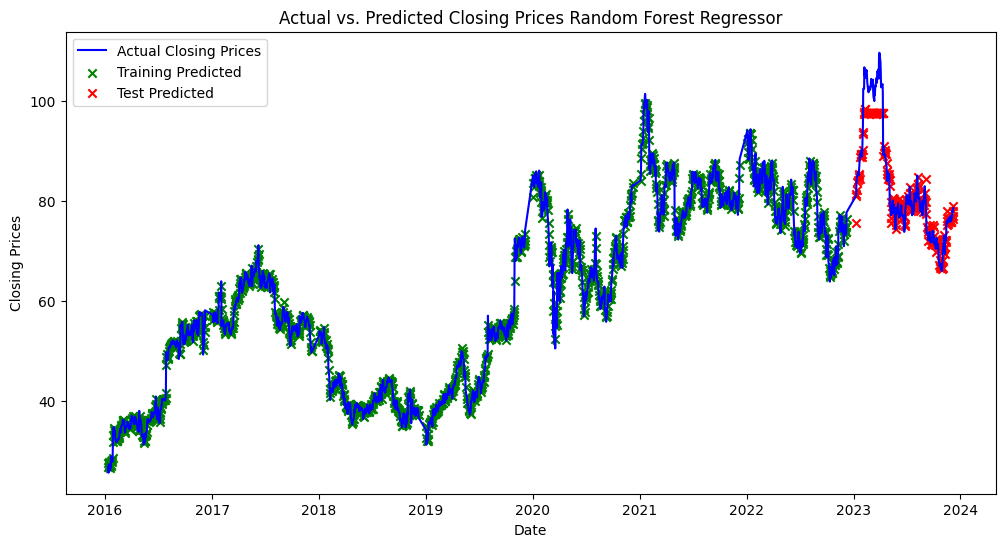

In [474]:
# Create a DataFrame with 'date' for visualization
date_df = df[['Date']]

# Plotting the actual and predicted closing prices
plt.figure(figsize=(12, 6))
plt.plot(date_df['Date'], df['Close'], label='Actual Closing Prices', color='blue')
# plt.scatter(date_df.loc[X_train.index, 'Date'], y_train, label='Training Actual', color='green', marker='o')
plt.scatter(date_df.loc[X_train.index, 'Date'], model.predict(X_train), label='Training Predicted', color='green', marker='x')
# plt.scatter(date_df.loc[X_test.index, 'Date'], y_test, label='Test Actual', color='red', marker='o')
plt.scatter(date_df.loc[X_test.index, 'Date'], predictions, label='Test Predicted', color='red', marker='x')

plt.title('Actual vs. Predicted Closing Prices Random Forest Regressor')
plt.xlabel('Date')
plt.ylabel('Closing Prices')
plt.legend()
plt.show()

### XGBRegressor

In [475]:
# Instantiate and train the model
model = XGBRegressor(n_estimators=100, objective='reg:squarederror', random_state=42)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [476]:
# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 10.179596922776346


In [477]:
xgb_accuracy = model.score(X_test, y_test)
print(f"XGBRegressor Accuracy: {xgb_accuracy}")

XGBRegressor Accuracy: 0.9237988872254659


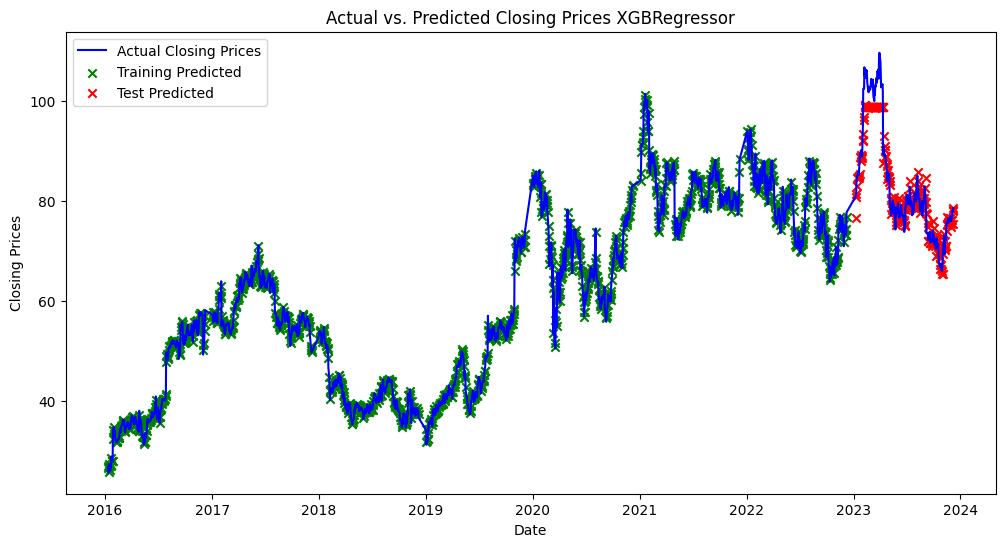

In [478]:
# Create a DataFrame with 'date' for visualization
date_df = df[['Date']]

# Plotting the actual and predicted closing prices
plt.figure(figsize=(12, 6))
plt.plot(date_df['Date'], df['Close'], label='Actual Closing Prices', color='blue')
# plt.scatter(date_df.loc[X_train.index, 'Date'], y_train, label='Training Actual', color='green', marker='o')
plt.scatter(date_df.loc[X_train.index, 'Date'], model.predict(X_train), label='Training Predicted', color='green', marker='x')
# plt.scatter(date_df.loc[X_test.index, 'Date'], y_test, label='Test Actual', color='red', marker='o')
plt.scatter(date_df.loc[X_test.index, 'Date'], predictions, label='Test Predicted', color='red', marker='x')

plt.title('Actual vs. Predicted Closing Prices XGBRegressor')
plt.xlabel('Date')
plt.ylabel('Closing Prices')
plt.legend()
plt.show()

## Extrapolating Data

In [479]:
new_df = pd.DataFrame(columns=features)

In [480]:
# Creating first row of the new dataframe
new_row_values = list(df.tail(5)["Close"][::-1].values)
new_df.loc[0] = new_row_values

In [481]:
predicted_value = model.predict(new_df)[0]

In [482]:
num_days = 30
for i in range(num_days-1):
    new_row_values.pop(-1)
    new_row_values.insert(0, predicted_value)
    new_df.loc[i + 1] = new_row_values
    predicted_value = model.predict(new_df)[i+1]

In [483]:
base = datetime.datetime.today()
date_list = [base + datetime.timedelta(days=x) for x in range(num_days)]

In [484]:
for i in range(len(date_list)):
    date_list[i] = date_list[i].strftime("%Y-%m-%d")

In [485]:
new_predictions = model.predict(new_df)

In [486]:
new_df["Date"] = date_list
new_df["Date"] = pd.to_datetime(new_df["Date"])

In [487]:
# Printing out the stock price at each forecasted day
for date, stock in list(zip(date_list, new_predictions)):
    print(f"The stock price on {date} is predicted to be {stock:.2f} USD")

The stock price on 2023-12-11 is predicted to be 79.70 USD
The stock price on 2023-12-12 is predicted to be 80.67 USD
The stock price on 2023-12-13 is predicted to be 80.25 USD
The stock price on 2023-12-14 is predicted to be 80.60 USD
The stock price on 2023-12-15 is predicted to be 80.57 USD
The stock price on 2023-12-16 is predicted to be 78.65 USD
The stock price on 2023-12-17 is predicted to be 79.53 USD
The stock price on 2023-12-18 is predicted to be 80.61 USD
The stock price on 2023-12-19 is predicted to be 80.71 USD
The stock price on 2023-12-20 is predicted to be 79.71 USD
The stock price on 2023-12-21 is predicted to be 80.28 USD
The stock price on 2023-12-22 is predicted to be 80.54 USD
The stock price on 2023-12-23 is predicted to be 79.66 USD
The stock price on 2023-12-24 is predicted to be 79.65 USD
The stock price on 2023-12-25 is predicted to be 80.34 USD
The stock price on 2023-12-26 is predicted to be 80.65 USD
The stock price on 2023-12-27 is predicted to be 79.89 U

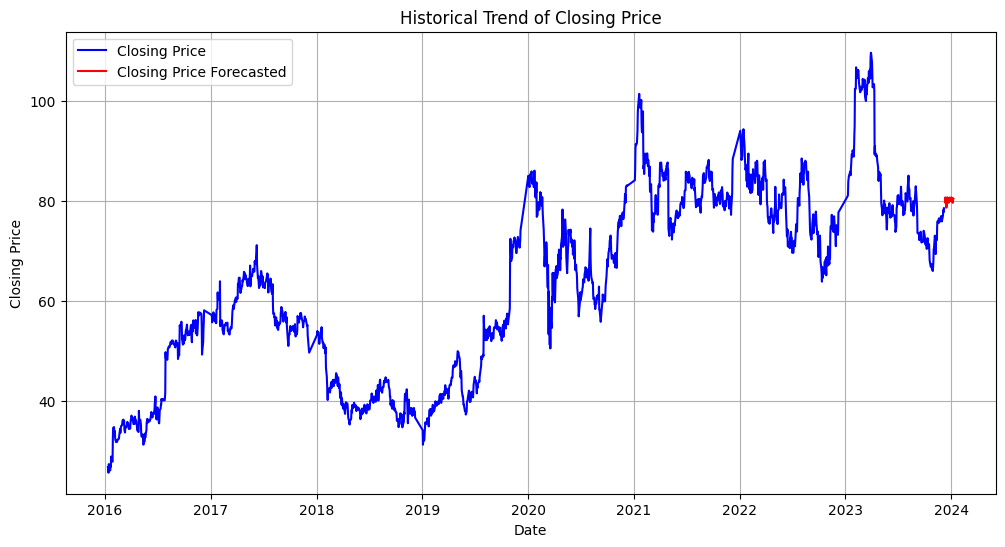

In [488]:
# Plotting the historical trend of the closing price
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], label='Closing Price', color='blue')
plt.plot(new_df['Date'], new_predictions, label='Closing Price Forecasted', color='red')
plt.title('Historical Trend of Closing Price')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.show()

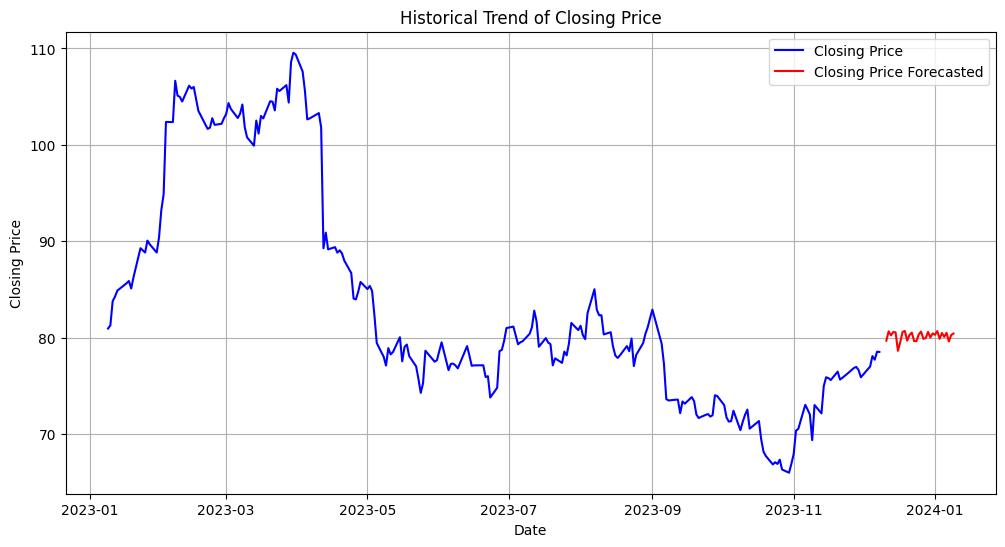

In [489]:
# Plotting the historical trend of the closing price
cutoff_year = 2023
cutoff_df = df[df["Date"].dt.year >= 2023]

plt.figure(figsize=(12, 6))
plt.plot(cutoff_df['Date'], cutoff_df['Close'], label='Closing Price', color='blue')
plt.plot(new_df['Date'], new_predictions, label='Closing Price Forecasted', color='red')
plt.title('Historical Trend of Closing Price')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.show()